# DSN AI Bootcamp

#### Predicting price of houses in Nigeria

In [2]:
# import libraries to be used in the notebook
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in the data
train = pd.read_csv("Housing_dataset_train.csv")
test = pd.read_csv("Housing_dataset_test.csv")
sub = pd.read_csv("Sample_submission.csv")

In [4]:
# view a random sample of the data
train.sample(5)

,ID,loc,title,bedroom,bathroom,parking_space,price
9741,11559,Osun,Mansion,7.0,1.0,1.0,4.170440e+06
7250,12037,Osun,Detached duplex,7.0,3.0,3.0,2.850660e+06
6005,146,Anambra,Terrace duplex,1.0,1.0,3.0,1.297916e+06
5634,1507,Zamfara,Flat,1.0,6.0,4.0,9.450278e+05
5051,1137,Kano,NaN,1.0,2.0,NaN,1.393493e+06


In [5]:
# check for number of rows and columns
train.shape

(14000, 7)

In [6]:
# view statistical inference of the data
train.describe()

,ID,bedroom,bathroom,parking_space,price
count,14000.000000,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4862.700357,4.308171,3.134235,3.169825,2.138082e+06
std,3818.348214,2.441165,2.035950,1.599415,1.083057e+06
min,0.000000,1.000000,1.000000,1.000000,4.319673e+05
25%,1672.750000,2.000000,1.000000,2.000000,1.393990e+06
50%,3527.000000,4.000000,2.000000,3.000000,1.895223e+06
75%,8011.250000,6.000000,5.000000,4.000000,2.586699e+06
max,12999.000000,9.000000,7.000000,6.000000,1.656849e+07


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB


The dataset has some null values. Null values can be very tricky to deal with so we leave them since the model we're using doesn't require the absence of null values.

In [8]:
# view first five rows of the test dataset
test.head()

,ID,loc,title,bedroom,bathroom,parking_space
0,845,Kano,Penthouse,4,1,2
1,1924,Adamawa,Apartment,2,2,4
2,10718,Adamawa,Bungalow,2,7,2
3,12076,Lagos,Mansion,9,5,2
4,12254,Gombe,Semi-detached duplex,5,6,1


In [9]:
sub.head()

,ID
0,845
1,1924
2,10718
3,12076
4,12254


##### Before exploring the data for insights, I want to separate the dataset into the six regions (South East, North West, etc.). This should help in getting insights.

In [10]:
states_zones_dict = {
     'Abia': 'South East',
     'Adamawa': 'North East',
     'Akwa Ibom': 'South South',
     'Anambra': 'South East',
     'Bauchi': 'North East',
     'Bayelsa': 'South South',
     'Benue': 'North Central',
     'Borno': 'North East',
     'Cross River': 'South South',
     'Delta': 'South South',
     'Ebonyi': 'South East',
     'Edo': 'South South',
     'Ekiti': 'South West',
     'Enugu': 'South East',
     'Gombe': 'North East',
     'Imo': 'South East',
     'Jigawa': 'North West',
     'Kaduna': 'North West',
     'Kano': 'North West',
     'Katsina': 'North West',
     'Kebbi': 'North West',
     'Kogi': 'North Central',
     'Kwara': 'North Central',
     'Lagos': 'South West',
     'Nasarawa': 'North Central',
     'Niger': 'North Central',
     'Ogun': 'South West',
     'Ondo': 'South West',
     'Osun': 'South West',
     'Oyo': 'South West',
     'Plateau': 'North Central',
     'Rivers': 'South South',
     'Sokoto': 'North West',
     'Taraba': 'North East',
     'Yobe': 'North East',
     'Zamfara': 'North West'
}

In [11]:
# Map the 'loc' column to its corresponding frequency values
train['zones'] = train['loc'].map(states_zones_dict)

# Print the updated dataframe
train.head()


,ID,loc,title,bedroom,bathroom,parking_space,price,zones
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,North West
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689,South West
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814,South West
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,South East
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898,North Central


## Exploratory Data Analysis

In [12]:
# set color for all visualizations
base_color = sns.color_palette()[9]

### Distribution of House titles in the dataset

In [13]:
house_titles = train.title.value_counts()

house_titles

Flat                    1372
Apartment               1331
Townhouse               1327
Mansion                 1322
Detached duplex         1312
Penthouse               1306
Semi-detached duplex    1299
Bungalow                1293
Terrace duplex          1266
Cottage                  450
Name: title, dtype: int64

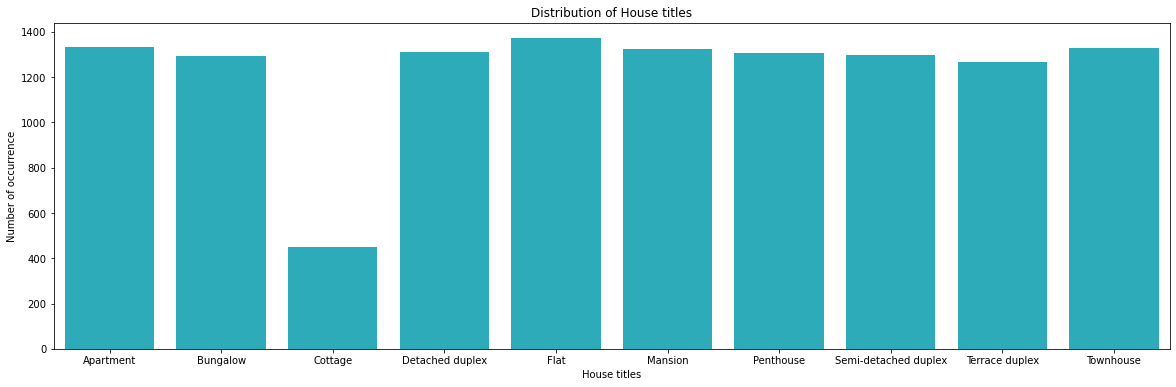

In [14]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=house_titles.index, y='title', data=house_titles.to_frame(), 
            order=house_titles.sort_index().index, color=base_color);

# necessary labels and title
plt.title('Distribution of House titles');
plt.xlabel('House titles');
plt.ylabel('Number of occurrence');

The distribution of house types in the dataset is evenly distributed for all except the `Cottage` house title.

### Distribution of houses by location in the dataset (Top 10)

In [15]:
# group the dataset by states and count any column for the number of houses for each state.
num_states = train.groupby('loc').count()['ID'].sort_values(ascending=False)[:10]

num_states

loc
Kaduna         370
Anambra        363
Benue          355
Yobe           353
Kano           351
Borno          351
Nasarawa       349
Cross River    349
Imo            348
Zamfara        348
Name: ID, dtype: int64

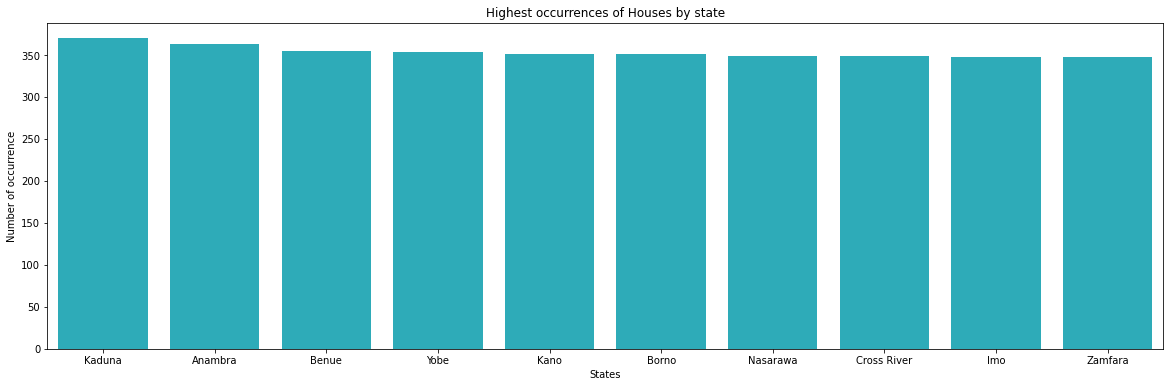

In [16]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=num_states.index, y='ID', data=num_states.to_frame(), 
            order=num_states.index, color=base_color);

# necessary labels and title
plt.title('Highest occurrences of Houses by state');
plt.xlabel('States');
plt.ylabel('Number of occurrence');

Kaduna is the state that occurs most frequently in the data. Although the rest of the states are not far off.

### Distribution of houses by location in the dataset (Bottom 10)

In [17]:
# group the dataset by states and count any column for the number of houses for each state.
num_states = train.groupby('loc').count()['ID'].sort_values()[:10]

num_states

loc
Edo          302
Abia         312
Taraba       315
Kogi         321
Rivers       323
Enugu        324
Delta        325
Sokoto       326
Lagos        328
Akwa Ibom    329
Name: ID, dtype: int64

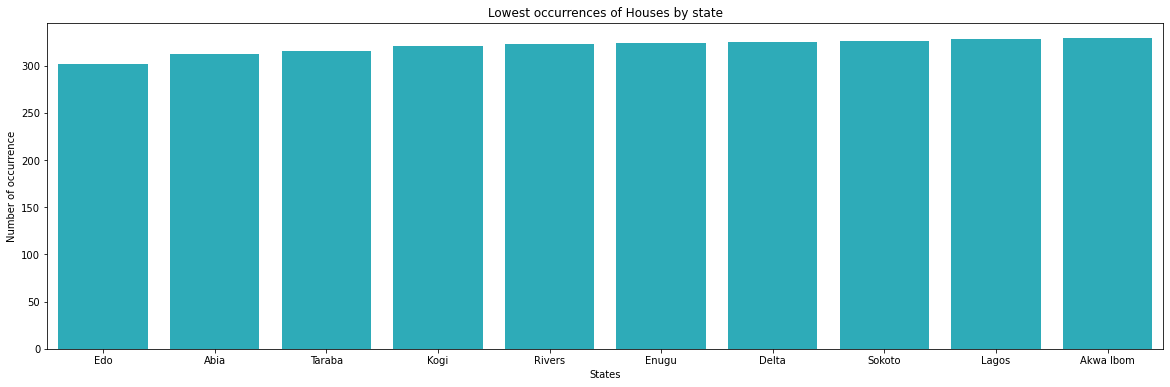

In [18]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=num_states.index, y='ID', data=num_states.to_frame(), 
            order=num_states.index, color=base_color);

# necessary labels and title
plt.title('Lowest occurrences of Houses by state');
plt.xlabel('States');
plt.ylabel('Number of occurrence');

Edo appears least in this dataset. It is not far off from Kaduna so the distribution of states in the dataset is even.

### Average price of houses by zones

In [19]:
# group the dataset by states and find the mean of the price column.
avg_zones = train.groupby('zones').mean()['price'].sort_values(ascending=False)

avg_zones

zones
South South      2.725881e+06
South West       2.596851e+06
South East       2.011843e+06
North Central    1.915043e+06
North East       1.811737e+06
North West       1.802017e+06
Name: price, dtype: float64

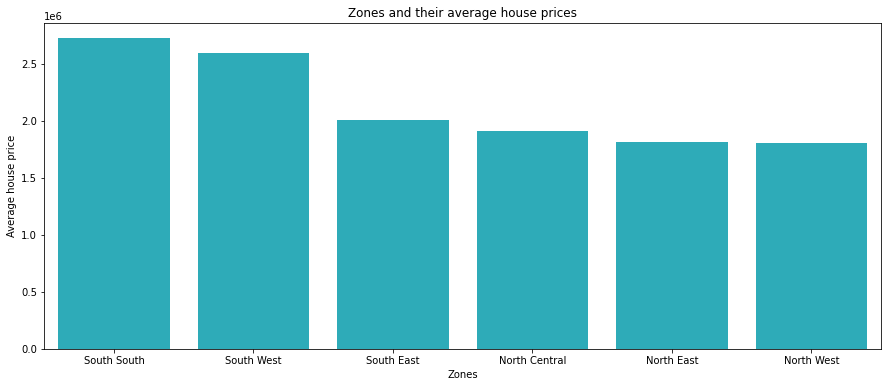

In [20]:
# choose the figure size of the plot
plt.figure(figsize=(15, 6))

# plot bar chart to display the information
sns.barplot(x=avg_zones.index, y='price', data=avg_zones.to_frame(), 
            order=avg_zones.index, color=base_color);

# necessary labels and title
plt.title('Zones and their average house prices');
plt.xlabel('Zones');
plt.ylabel('Average house price');

South South zone has the highest average house price, closely followed by South West. The North zones have the lowest average price while the South zones have the highest average price.

### Average price of houses by location (Top 10 highest)

In [21]:
# group the dataset by states and find the mean of the price column.
avg_states = train.groupby('loc').mean()['price'].sort_values(ascending=False)[:10]

avg_states

loc
Lagos          4.210546e+06
Bayelsa        3.112322e+06
Rivers         2.957098e+06
Akwa Ibom      2.725454e+06
Delta          2.712493e+06
Ogun           2.564020e+06
Cross River    2.507765e+06
Anambra        2.337230e+06
Edo            2.310452e+06
Oyo            2.293159e+06
Name: price, dtype: float64

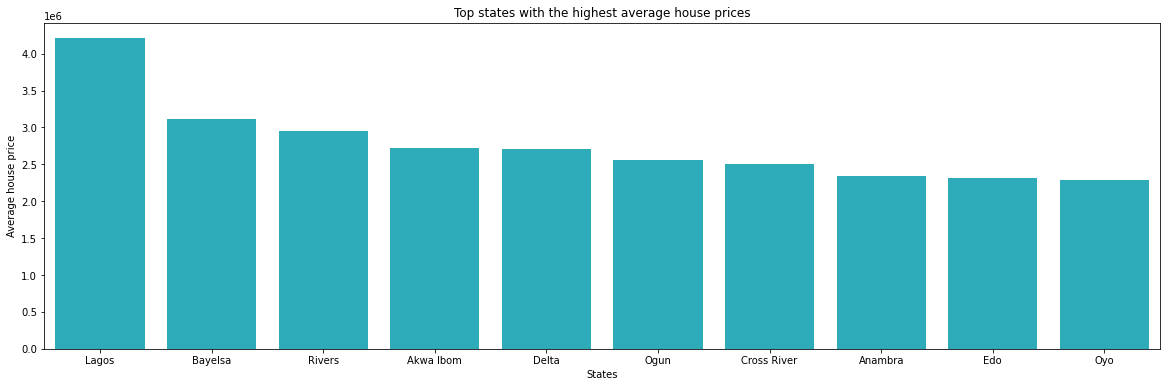

In [22]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_states.index, y='price', data=avg_states.to_frame(), 
            order=avg_states.index, color=base_color);

# necessary labels and title
plt.title('Top states with the highest average house prices');
plt.xlabel('States');
plt.ylabel('Average house price');

Lagos has the highest average house price. The difference from the next stat is quite a lot so on average we can say that houses in Lagos are quite high.

The South South zone has the highest average house price of all the zones. The prices of houses in Lagos could be increasing the average house prices in the South West zone.

In [23]:
# group the dataset by states and find the mean of the price column. Exclude Lagos state.
avg_zones = train[train['loc'] != 'Lagos'].groupby('zones').mean()['price'].sort_values(ascending=False)

avg_zones

zones
South South      2.725881e+06
South West       2.286234e+06
South East       2.011843e+06
North Central    1.915043e+06
North East       1.811737e+06
North West       1.802017e+06
Name: price, dtype: float64

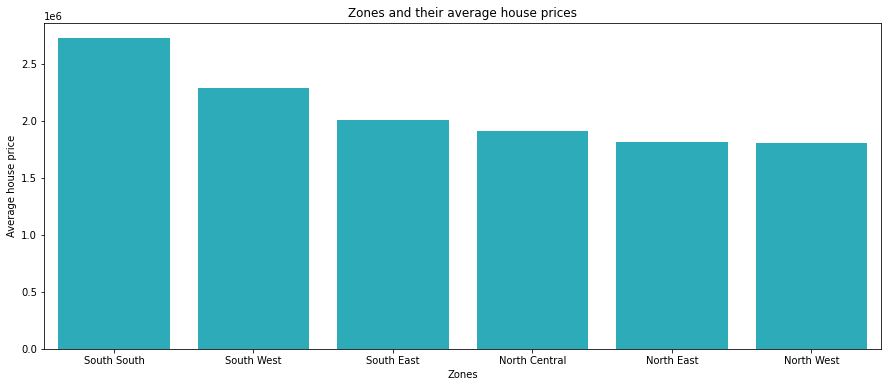

In [24]:
# choose the figure size of the plot
plt.figure(figsize=(15, 6))

# plot bar chart to display the information
sns.barplot(x=avg_zones.index, y='price', data=avg_zones.to_frame(), 
            order=avg_zones.index, color=base_color);

# necessary labels and title
plt.title('Zones and their average house prices');
plt.xlabel('Zones');
plt.ylabel('Average house price');

The average price for South West further establishing the gap between South West and South South. 

This also confirms the influence that Lagos state has on the average house price in the South West zone.

### Average price of houses by location (Top 10 lowest)

In [25]:
# group the dataset by states and find the mean of the price column.
avg_states = train.groupby('loc').mean()['price'].sort_values()[:10]

avg_states

loc
Kebbi      1.616372e+06
Ebonyi     1.635850e+06
Sokoto     1.681016e+06
Zamfara    1.689541e+06
Abia       1.717083e+06
Borno      1.735704e+06
Jigawa     1.735867e+06
Yobe       1.747938e+06
Kogi       1.763416e+06
Bauchi     1.772961e+06
Name: price, dtype: float64

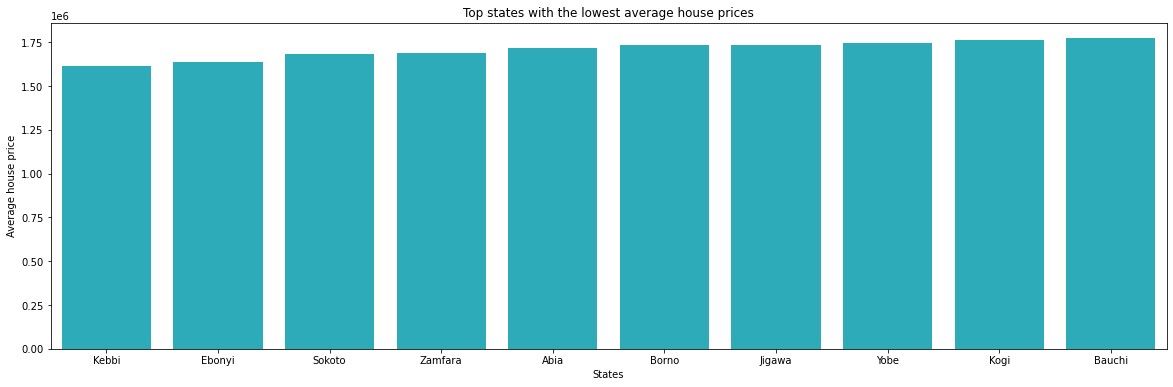

In [26]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_states.index, y='price', data=avg_states.to_frame(), 
            order=avg_states.index, color=base_color);

# necessary labels and title
plt.title('Top states with the lowest average house prices');
plt.xlabel('States');
plt.ylabel('Average house price');

Kebbi has the lowest average house price at 1.6 million. It is far from Lagos, which is at 4.2 million.

Notice that Abia state is the only state from the Southern zone that entered this top 10.

### Relationship between number of bedrooms and price

Text(0, 0.5, 'Price')

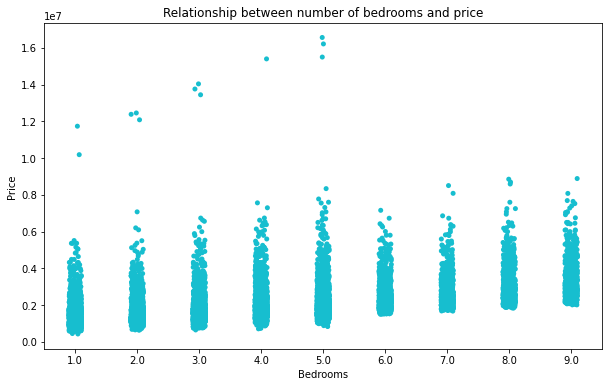

In [27]:
# Relationship between number of bedrooms and house price
# Using strip plit because of the jitter parameter. 
# Using a scatterplot would not be too useful because the x variable is categorical

# choose the figure size of the plot
plt.figure(figsize=(10, 6))

sns.stripplot(x=train['bedroom'], y=train['price'], color=base_color)

# labels and title
plt.title('Relationship between number of bedrooms and price')
plt.xlabel('Bedrooms')
plt.ylabel('Price')

As seen at the bottom of the strip plot, there is a correlation between price and number of bedrooms. As the number of bedrooms increase, the price increases.

### Relationship between number of bathrooms and price

Text(0, 0.5, 'Price')

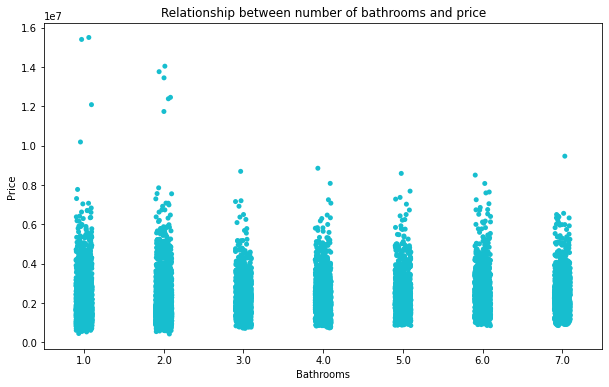

In [28]:
# Relationship between number of bathrooms and house price

# choose the figure size of the plot
plt.figure(figsize=(10, 6))

sns.stripplot(x=train['bathroom'], y=train['price'], color=base_color)

# labels and title
plt.title('Relationship between number of bathrooms and price')
plt.xlabel('Bathrooms')
plt.ylabel('Price')

There is no clear correlation between number of bathrooms and price. There are some unusually high values of price in the plot which could be as a result of other features like the type of house.

### Average number of bedrooms for each house title.

In [29]:
# group the dataset by states and find the mean of the price column.
avg_bedrooms = train.groupby('title').mean()['bedroom'].sort_values()[:10]

avg_bedrooms

title
Cottage                 2.905512
Townhouse               4.298759
Detached duplex         4.327840
Mansion                 4.333929
Terrace duplex          4.340639
Penthouse               4.342982
Apartment               4.344219
Flat                    4.378877
Bungalow                4.402852
Semi-detached duplex    4.414903
Name: bedroom, dtype: float64

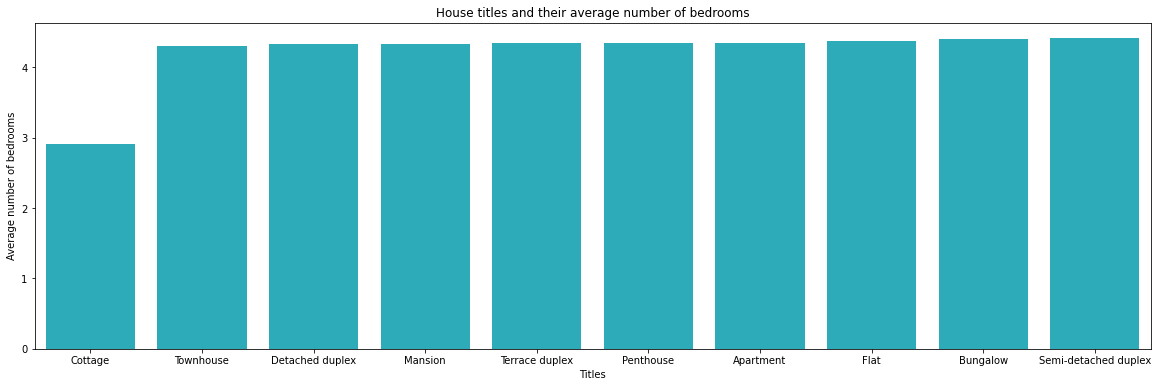

In [30]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_bedrooms.index, y='bedroom', data=avg_bedrooms.to_frame(), 
            order=avg_bedrooms.index, color=base_color);

# necessary labels and title
plt.title('House titles and their average number of bedrooms');
plt.xlabel('Titles');
plt.ylabel('Average number of bedrooms');

The average number of bedrooms is pretty much the same for all types of houses except the `Cottage` houe title

### Distribution of number of parking spaces in the dataset.

In [31]:
dist_parking_space = train.parking_space.value_counts()

dist_parking_space

4.0    2419
2.0    2394
3.0    2378
1.0    2324
6.0    1345
5.0    1329
Name: parking_space, dtype: int64

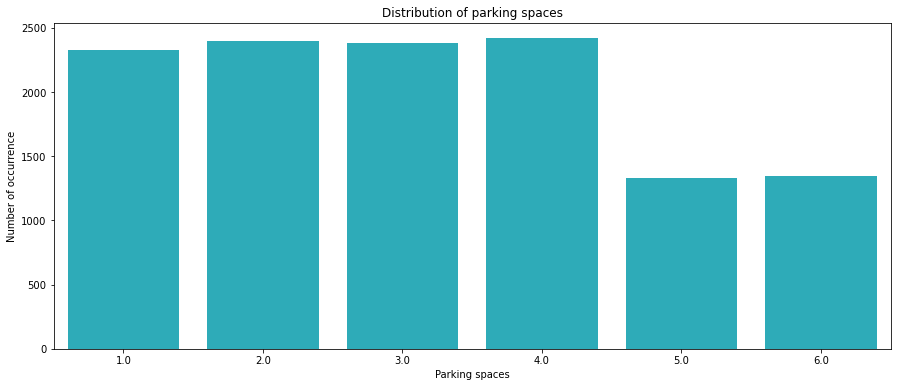

In [32]:
# choose the figure size of the plot
plt.figure(figsize=(15, 6))

# plot bar chart to display the information
sns.barplot(x=dist_parking_space.index, y='parking_space', data=dist_parking_space.to_frame(), 
            order=dist_parking_space.sort_index().index, color=base_color);

# necessary labels and title
plt.title('Distribution of parking spaces');
plt.xlabel('Parking spaces');
plt.ylabel('Number of occurrence');

A significant amount of houses in this dataset have 3 parking spaces. 1, 2 and 4 parking spaces are shared evenly. 5 and 6 parking spaces occur far less than the others.

### Are there outliers in the price column?

In [33]:
train.price.describe()

count    1.400000e+04
mean     2.138082e+06
std      1.083057e+06
min      4.319673e+05
25%      1.393990e+06
50%      1.895223e+06
75%      2.586699e+06
max      1.656849e+07
Name: price, dtype: float64

Let's check the samples that contain the minimum and maximum price to ensure that it makes sense.

In [34]:
train[train['price'] == train.price.min()]

,ID,loc,title,bedroom,bathroom,parking_space,price,zones
4481,2606,Gombe,Cottage,1.0,2.0,1.0,431967.29,North East


In [35]:
train[train['price'] == train.price.max()]

,ID,loc,title,bedroom,bathroom,parking_space,price,zones
7969,1073,Lagos,Mansion,5.0,NaN,3.0,16568486.16,South West


There doesn't seem to be outliers in the `price` column. As expected, the `Cottage` house title has the least price and the `Mansion` house title has the highest price.

### Average price of houses by number of bedrooms.

In [36]:
# group the dataset by bedrooms and find the mean of the price column.
avg_price_bedrooms = train.groupby('bedroom').mean()['price'].sort_values()

avg_price_bedrooms

bedroom
1.0    1.415794e+06
2.0    1.594927e+06
3.0    1.824883e+06
4.0    2.037854e+06
5.0    2.230842e+06
6.0    2.583971e+06
7.0    2.793135e+06
8.0    3.048735e+06
9.0    3.286542e+06
Name: price, dtype: float64

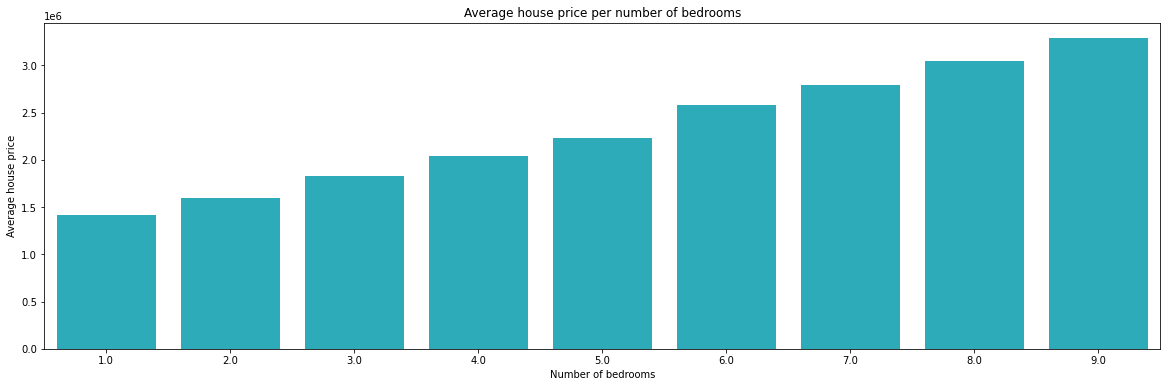

In [37]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_price_bedrooms.index, y='price', data=avg_price_bedrooms.to_frame(), 
            order=avg_price_bedrooms.index, color=base_color);

# necessary labels and title
plt.title('Average house price per number of bedrooms');
plt.xlabel('Number of bedrooms');
plt.ylabel('Average house price');

As seen in the plot above, as the number of bedrooms increase, the average house price increases. There seems to be a very strong correlation between number of bedrooms and house price

### Average price of houses by number of bathrooms.

In [38]:
# group the dataset by bathrooms and find the mean of the price column.
avg_price_bathrooms = train.groupby('bathroom').mean()['price'].sort_values()

avg_price_bathrooms

bathroom
1.0    1.875436e+06
2.0    1.939928e+06
3.0    2.270404e+06
5.0    2.386897e+06
4.0    2.395221e+06
7.0    2.460592e+06
6.0    2.486154e+06
Name: price, dtype: float64

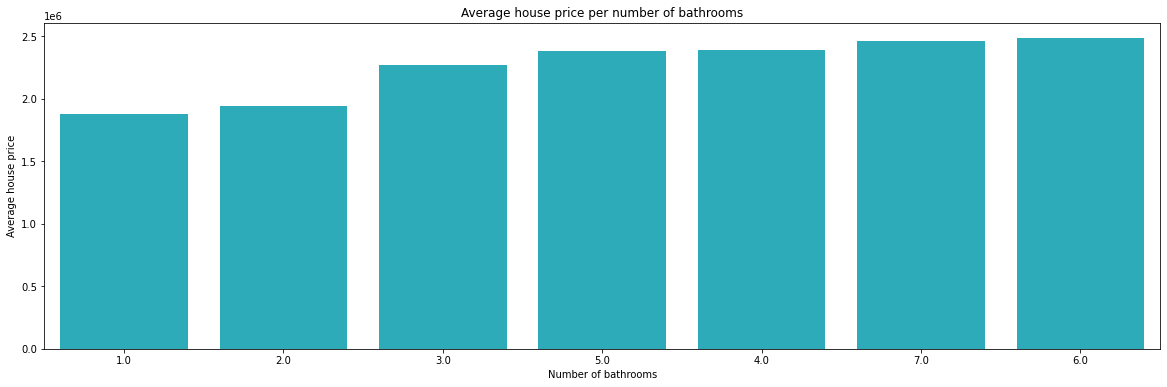

In [39]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_price_bathrooms.index, y='price', data=avg_price_bathrooms.to_frame(), 
            order=avg_price_bathrooms.index, color=base_color);

# necessary labels and title
plt.title('Average house price per number of bathrooms');
plt.xlabel('Number of bathrooms');
plt.ylabel('Average house price');

There seems to be an increase in average house prices as the number of bathrooms increase. It is not as distince as the `bedroom` column though

### Highest median house prices by location.

In [40]:
# group the dataset by bathrooms and find the mean of the price column.
median_price_states = train.groupby('loc').median()['price'].sort_values(ascending=False)[:10]

median_price_states

loc
Lagos          3.845226e+06
Bayelsa        2.844060e+06
Rivers         2.569030e+06
Akwa Ibom      2.505120e+06
Delta          2.401926e+06
Ogun           2.348871e+06
Cross River    2.209130e+06
Ondo           2.094914e+06
Anambra        2.092779e+06
Enugu          2.020827e+06
Name: price, dtype: float64

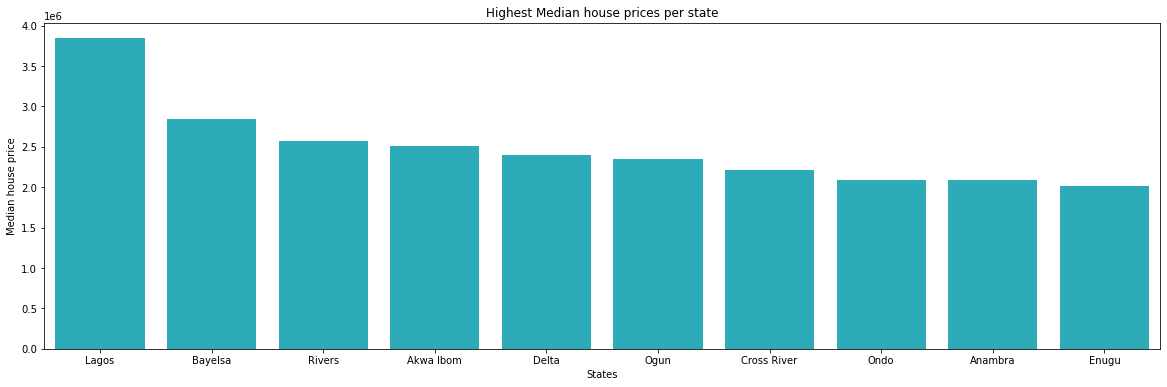

In [41]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=median_price_states.index, y='price', data=median_price_states.to_frame(), 
            order=median_price_states.index, color=base_color);

# necessary labels and title
plt.title('Highest Median house prices per state');
plt.xlabel('States');
plt.ylabel('Median house price');

Lagos has the highest median price out of all the states. 

The top 10 highest median prices by state is a bit different from the top 10 highest average prices by state. This suggests that there are some houses in some states with very high or very low house prices that is manipulating the average values.

###  Lowest median house prices by location.

In [42]:
# group the dataset by bathrooms and find the mean of the price column.
median_price_states = train.groupby('loc').median()['price'].sort_values()[:10]

median_price_states

loc
Ebonyi     1.454981e+06
Borno      1.480444e+06
Kebbi      1.495141e+06
Zamfara    1.541111e+06
Abia       1.544623e+06
Yobe       1.550091e+06
Sokoto     1.558253e+06
Bauchi     1.570721e+06
Jigawa     1.603510e+06
Kogi       1.605070e+06
Name: price, dtype: float64

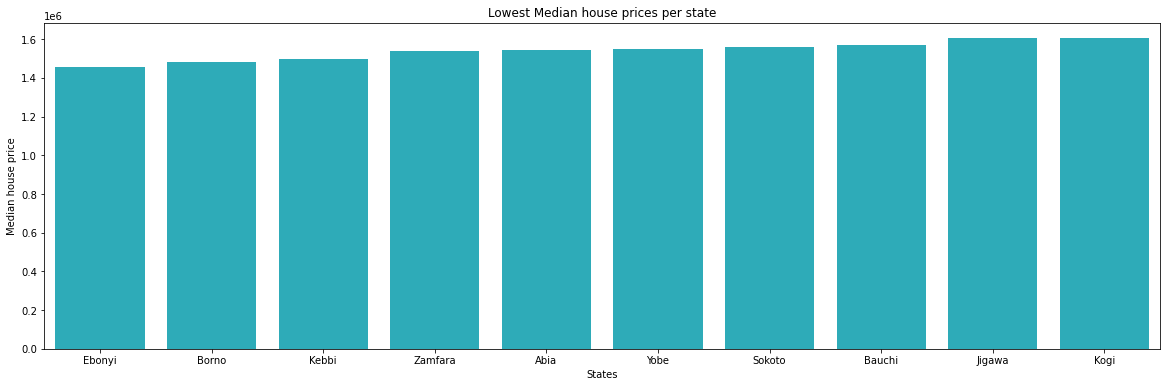

In [43]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=median_price_states.index, y='price', data=median_price_states.to_frame(), 
            order=median_price_states.index, color=base_color);

# necessary labels and title
plt.title('Lowest Median house prices per state');
plt.xlabel('States');
plt.ylabel('Median house price');

Ebonyi has the lowest median house price out of all the states. This is different from the lowest average house price.

The Northern states still make up most of the top 10 here. Only Abia and Ebonyi are Southern states. South-east specifically.

### Average house price by title 

In [44]:
# group the dataset by title and find the mean of the price column.
avg_price_title = train.groupby('title').mean()['price'].sort_values(ascending=False)

avg_price_title

title
Mansion                 3.725768e+06
Penthouse               2.628945e+06
Detached duplex         2.205883e+06
Townhouse               2.056125e+06
Terrace duplex          1.927270e+06
Semi-detached duplex    1.918468e+06
Bungalow                1.733845e+06
Flat                    1.721875e+06
Apartment               1.567004e+06
Cottage                 1.307817e+06
Name: price, dtype: float64

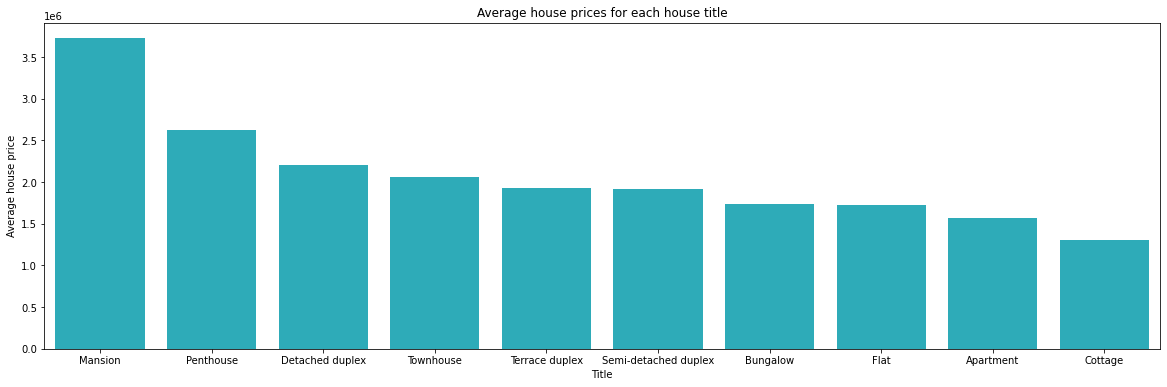

In [45]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_price_title.index, y='price', data=avg_price_title.to_frame(), 
            order=avg_price_title.index, color=base_color);

# necessary labels and title
plt.title('Average house prices for each house title');
plt.xlabel('Title');
plt.ylabel('Average house price');

As expected, the `Mansion` has the highest average house price and the `Cottage` has the lowest average house price.

### Is there a correlation between the number of bedrooms and bathrooms?

Text(0.5, 1.0, 'Relationship between Number of bedrooms and Number of bathrooms')

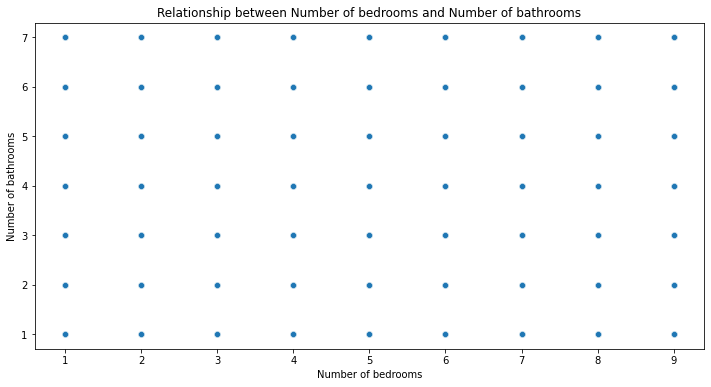

In [46]:
# choose the figure size of the plot
plt.figure(figsize=(12, 6))

# plot relationship between bedroom and bathroom using scatterplot
sns.scatterplot(x=train['bedroom'], y=train['bathroom']);

# Add necessary labels and title
plt.xlabel('Number of bedrooms')
plt.ylabel('Number of bathrooms')
plt.title('Relationship between Number of bedrooms and Number of bathrooms')

From the plot above, there is no clear correlation between number of bedrooms and number of bathrooms.

### Highest price for each of the house types

In [47]:
max_price_title = train.groupby('title').max()['price'].sort_values(ascending=False)

max_price_title

title
Mansion                 1.656849e+07
Penthouse               8.342144e+06
Detached duplex         6.145977e+06
Terrace duplex          5.669571e+06
Townhouse               5.369145e+06
Cottage                 5.359255e+06
Semi-detached duplex    4.994274e+06
Flat                    4.966246e+06
Bungalow                4.703051e+06
Apartment               4.159241e+06
Name: price, dtype: float64

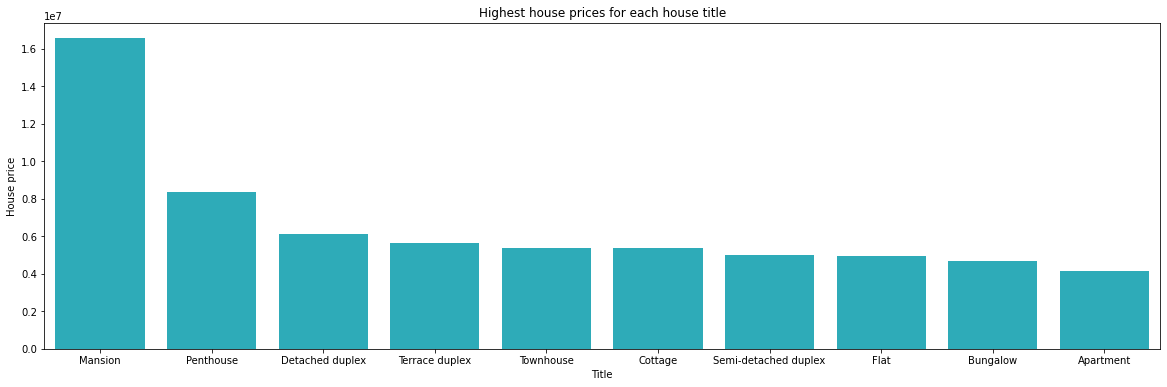

In [48]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=max_price_title.index, y='price', data=max_price_title.to_frame(), 
            order=max_price_title.index, color=base_color);

# necessary labels and title
plt.title('Highest house prices for each house title');
plt.xlabel('Title');
plt.ylabel('House price');

This plot shows the most expensive houses for each house type. Surprisingly, `Cottage` is not at the last position, it's `Apartment`

In [49]:
train[train['title'] == 'Cottage'].sort_values(by='price', ascending=False).head()

,ID,loc,title,bedroom,bathroom,parking_space,price,zones
1738,1050,Lagos,Cottage,5.0,1.0,NaN,5359255.239,South West
11464,2428,Lagos,Cottage,NaN,2.0,2.0,4863928.203,South West
12466,3188,Lagos,Cottage,4.0,1.0,NaN,4851586.158,South West
11188,2681,Lagos,Cottage,NaN,2.0,NaN,4820875.479,South West
2001,487,Lagos,Cottage,4.0,1.0,2.0,4639239.258,South West


Looking at the most expensive Cottage, we see that it's based in Lagos, a state we've established has unusually high house prices.

### Average number of bedrooms by house type.

In [50]:
# group the dataset by title and find the mean of the bedroom column.
avg_bedrooms_title = train.groupby('title').mean()['bedroom'].sort_values(ascending=False)

avg_bedrooms_title

title
Semi-detached duplex    4.414903
Bungalow                4.402852
Flat                    4.378877
Apartment               4.344219
Penthouse               4.342982
Terrace duplex          4.340639
Mansion                 4.333929
Detached duplex         4.327840
Townhouse               4.298759
Cottage                 2.905512
Name: bedroom, dtype: float64

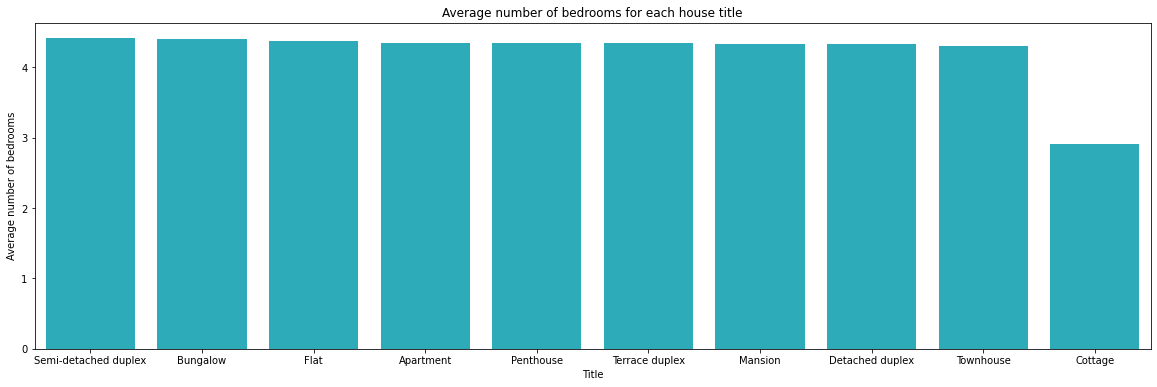

In [51]:
# choose the figure size of the plot
plt.figure(figsize=(20, 6))

# plot bar chart to display the information
sns.barplot(x=avg_bedrooms_title.index, y='bedroom', data=avg_bedrooms_title.to_frame(), 
            order=avg_bedrooms_title.index, color=base_color);

# necessary labels and title
plt.title('Average number of bedrooms for each house title');
plt.xlabel('Title');
plt.ylabel('Average number of bedrooms');

The average number of bedrooms for each house type is surprisingly equal for most house types including the `Mansion` house type. The only exception is the `Cottage` house type which has a smaller average number than the rest.

### Heatmap to show correlation between variables

<AxesSubplot:>

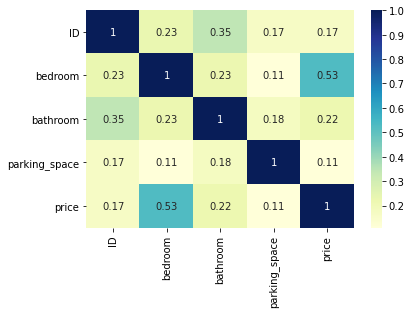

In [52]:
sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

## Feature Engineering

In [53]:
# Map the 'loc' column to its corresponding frequency values
test['zones'] = test['loc'].map(states_zones_dict)

In [54]:
# drop the price column from the train data so we can combine with the test data
data = train.drop("price", axis=1).append(test)

In [55]:
# Define the ranking based on size (arranged from smallest to biggest)
house_type_ranks = {
    'Cottage': 1,
    'Bungalow': 2,
    'Townhouse': 3,
    'Terrace duplex': 4,
    'Detached duplex': 5,
    'Semi-detached duplex': 6,
    'Flat': 7,
    'Penthouse': 8,
    'Apartment': 9,
    'Mansion': 10
}

# Map the house types to numerical values based on size ranking
data['title'] = data['title'].map(house_type_ranks)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,zones
0,3583,Katsina,6.0,2.0,2.0,1.0,North West
1,2748,Ondo,9.0,NaN,2.0,4.0,South West
2,9261,Ekiti,NaN,7.0,5.0,NaN,South West
3,2224,Anambra,5.0,5.0,2.0,4.0,South East
4,10300,Kogi,4.0,NaN,5.0,6.0,North Central


In [56]:
# Calculate the frequency of each category in the 'loc' and 'zones' column
category_frequencies = data['loc'].value_counts(normalize=True)
category_frequencies_z = data['zones'].value_counts(normalize=True)

# Create a dictionary to map each category to its corresponding frequency
loc_frequency_mapping = category_frequencies.to_dict()
zones_frequency_mapping = category_frequencies_z.to_dict()

# Map the 'loc' and 'zones' column to its corresponding frequency values
data['loc'] = data['loc'].map(loc_frequency_mapping)
data['zones'] = data['zones'].map(zones_frequency_mapping)

# Print the updated dataframe
data.head()


,ID,loc,title,bedroom,bathroom,parking_space,zones
0,3583,0.028592,6.0,2.0,2.0,1.0,0.197229
1,2748,0.028097,9.0,NaN,2.0,4.0,0.169297
2,9261,0.027822,NaN,7.0,5.0,NaN,0.169297
3,2224,0.029856,5.0,5.0,2.0,4.0,0.137791
4,10300,0.027382,4.0,NaN,5.0,6.0,0.166328


In [57]:
# Create new feature, bathroom to bedroom ratio
data['bed_ratio_bat'] = data['bedroom'] / data['bathroom']

data.head()

,ID,loc,title,bedroom,bathroom,parking_space,zones,bed_ratio_bat
0,3583,0.028592,6.0,2.0,2.0,1.0,0.197229,1.0
1,2748,0.028097,9.0,NaN,2.0,4.0,0.169297,NaN
2,9261,0.027822,NaN,7.0,5.0,NaN,0.169297,1.4
3,2224,0.029856,5.0,5.0,2.0,4.0,0.137791,2.5
4,10300,0.027382,4.0,NaN,5.0,6.0,0.166328,NaN


In [58]:
train.shape[0]

14000

In [59]:
# creae feature and target variables
X = data[:train.shape[0]]
y = train.price
test_df = data[train.shape[0]:]

In [60]:
X.shape, y.shape, test_df.shape

((14000, 8), (14000,), (6000, 8))

Next, we try to see if we can transform the target variable (`price`) to make the distribution look normal

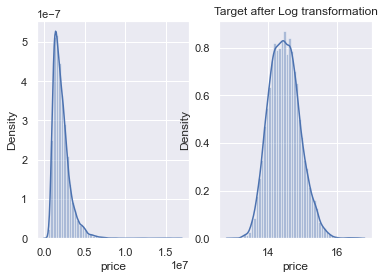

In [61]:
sns.set()
y_transformed = pd.Series(np.log1p(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed, ax=ax[1])
plt.show()

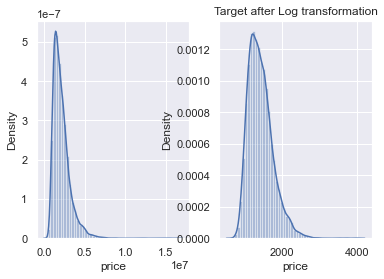

In [73]:
sns.set()
y_transformed_sqrt = pd.Series(np.sqrt(y))

fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])
plt.title("Target after Log transformation")
# ax[0].axvline(y_transformed)
sns.distplot(y_transformed_sqrt, ax=ax[1])
plt.show()

In [63]:
# split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [64]:
# create lgbm object, fit and predict on test set
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_preds = lgb.predict(X_test)

print(f'mse = {mean_squared_error(y_test, lgb_preds, squared=False)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 8
[LightGBM] [Info] Start training from score 14.471602
mse = 0.19676091956431413


In [65]:
predictions = lgb.predict(test_df)
predictions

array([14.60621154, 13.79170545, 13.97894005, ..., 14.60204005,
       14.14632617, 15.01449864])

In [66]:
# return the predictions back to its previous state
predictions = np.expm1(predictions)
predictions

array([2204940.50815255,  976474.99689443, 1177541.32713809, ...,
       2195761.78061019, 1392102.07964941, 3316757.93877126])

In [67]:
sub['price'] = predictions
sub.head()

,ID,price
0,845,2.204941e+06
1,1924,9.764750e+05
2,10718,1.177541e+06
3,12076,6.995186e+06
4,12254,1.919234e+06


In [ ]:
sub.to_csv('baseline model 7.csv', index=False)

In [68]:
fold_pred=[]
oof_pred = []

params = {
    'n_estimators': 500,
    'colsample_bytree': 0.86,
 'learning_rate': 0.032,
 'max_depth': 7,
 'subsample': 0.85}


fold = KFold(n_splits=7, shuffle=True)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    model = LGBMRegressor(**params, objective = "rmse")
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])#erly100

    preds= model.predict(X_test)
    print("err: ",(mean_squared_error(y_test,np.expm1(preds), squared=False)))  #Reverse transformation
    oof_pred.append(mean_squared_error(y_test,np.expm1(preds),squared=False))
    p2 = model.predict(test_df[X.columns])
    fold_pred.append(np.expm1(p2))
    

print(np.mean(oof_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 14.471935
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
err:  481999.90773529554
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
err:  574546.6054843519
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
541703.816209606


Text(0.5, 1.0, 'LGBMRegressor features importance (top 50):')

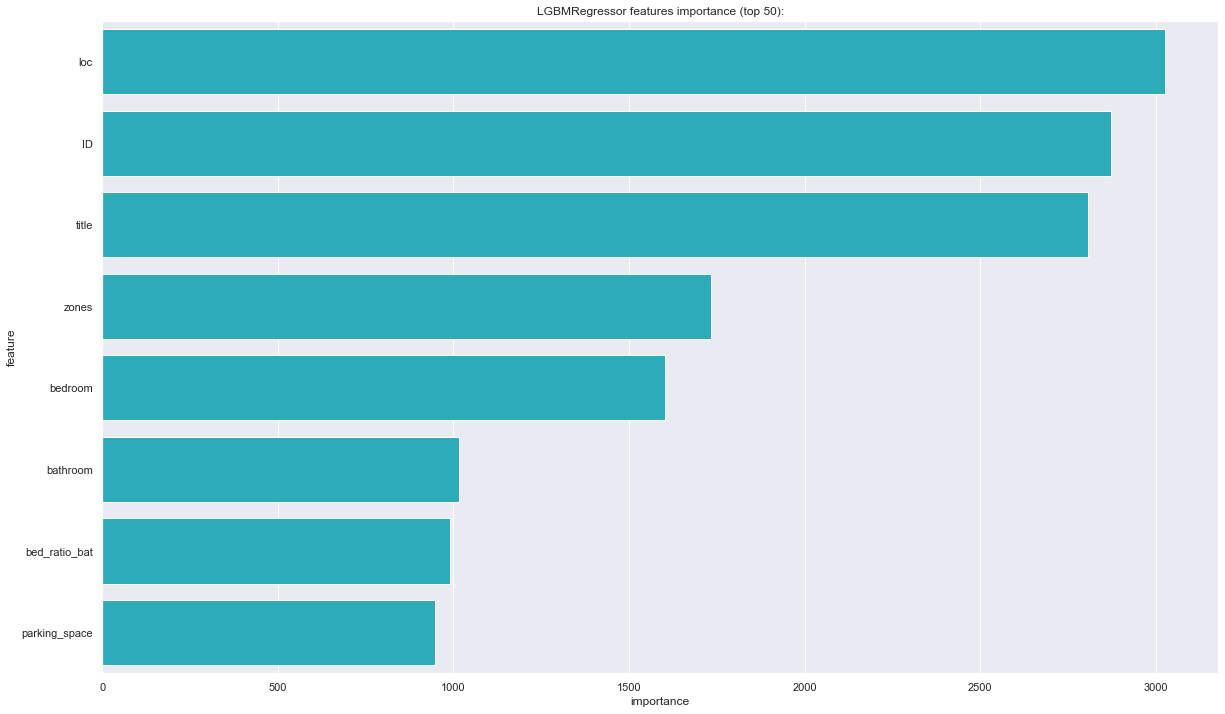

In [74]:
# plot the feature importances ofthe model we built
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", color=base_color,
            data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('LGBMRegressor features importance (top 50):')

In [70]:
sub.head()

,ID,price
0,845,2.204941e+06
1,1924,9.764750e+05
2,10718,1.177541e+06
3,12076,6.995186e+06
4,12254,1.919234e+06


In [71]:
sub['price'] =  np.mean(fold_pred, axis = 0)

In [72]:
sub.head()

,ID,price
0,845,2.267467e+06
1,1924,9.710923e+05
2,10718,1.216795e+06
3,12076,7.540286e+06
4,12254,1.889908e+06


In [ ]:
sub.to_csv('LGB kfold_7 Baseline submission 7.csv', index=False)

--------------------------------------------------------------------------------------------------------------------------------